In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [27]:
#variaveis de gating soma
def gating_soma(Vs):
    alpha_h = 128*np.exp(-(Vs+0.043) / 0.018)
    beta_h = 4e3/(1+np.exp(-200*(Vs+0.020)))
    beta_n = 250*np.exp(-25*(Vs+0.040))

    if Vs == -0.0469:
        alpha_m = 320/0.25
    else:
        alpha_m = ( 320*1e3*(Vs+0.0469) ) / (1-np.exp(-250*(Vs+0.0469)))

    if Vs == -0.0249:
        alpha_n = 16/0.2
    else:
        alpha_n = ( 16e3*(Vs+0.0249) ) / (1-np.exp(-200*(Vs+0.0249)))

    if Vs == -19.9:
        beta_m = 280/0.2
    else:
        beta_m = (280e3*(Vs+0.0199))/(np.exp(200*(Vs+0.0199))-1)

    return alpha_m, alpha_h, alpha_n, beta_m, beta_h, beta_n

In [28]:
#variaveis de gating dendrito
def gating_dend(Vd, Ca):
    alpha_mca = 1600/(1+np.exp(-72*(Vd-0.005)))
    alpha_mkahp = min(20,20e3*Ca)
    beta_mkahp = 4

    if Vd == -0.0089:
        beta_mca = 20/0.2
    else:
        beta_mca = 20e3*(Vd+0.0089)/(np.exp(200*(Vd+0.0089))-1)

    if Vd > -0.010:
        alpha_mkca = 2e3*np.exp(-(0.0535+Vd)/0.027)
        beta_mkca = 0
    else:
        alpha_mkca = np.exp( (Vd+0.050) / 0.011 - (Vd+0.0535) / 0.027 ) / 0.018975
        beta_mkca = (2e3*np.exp(-(0.0535+Vd)/0.027) - alpha_mkca)

    return alpha_mca, alpha_mkca, alpha_mkahp, beta_mca, beta_mkca, beta_mkahp

In [29]:
E_L = -0.060   # leak reversal potential
E_Na = 0.060   # reversal for sodium channels
E_K = -0.075   # reversal for potassium channels
E_Ca = 0.080   # reversal for calcium channels

p = 1/3

# Conductance values for somatic channels follow
G_LS = 5e-9*p     # somatic leak conductance in Siemens
G_Na = 3e-6*p    # sodium conductance (Soma)
G_K = 2e-6*p     # potassium conductance (Soma)

# Conductance values for dendritic channels follow
G_LD = 5e-9*(1-p)       # dendritic leak conductance in Siemens
G_Ca = 2e-6*(1-p)          # calcium conductance (Dendrite)
G_KAHP = 0.04e-6*(1-p)     # Potassium conductance to generate after-hyperpolarization
G_KCa = 2.5e-6*(1-p)     # calcium-dependent Potassium conductance

tau_Ca = 50e-3              # time constant for buffering of calcium
convert_Ca = 0.5e7/(1-p)    # conversion changing calcium charge entry per unit area into concentration

CmS = 100e-12*p     # somatic membrane capacitance in Farads
CmD = 100e-12*(1-p)       # dendritic membrane capacitance in Farads

In [30]:
t = np.arange(0, 2, 0.00005)
IS_inj = 0e-12
ID_inj = 0e-12

# <center>Gráficos para Gc = 0 nS</center>

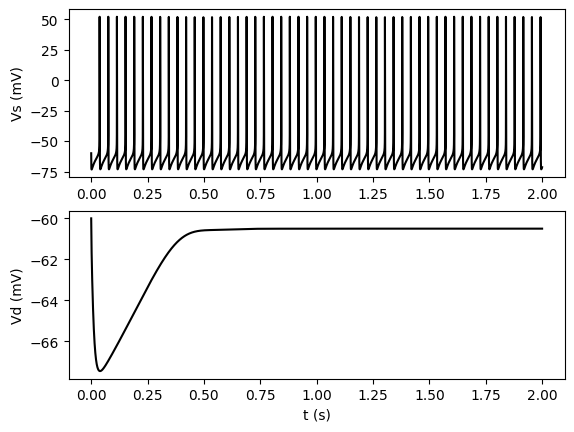

In [31]:
G_Link = 0

def dALLdt(X,t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp = X

    alpha_m, alpha_h, alpha_n, beta_m, beta_h, beta_n = gating_soma(Vs)
    alpha_mca, alpha_mkca, alpha_mkahp, beta_mca, beta_mkca, beta_mkahp = gating_dend(Vd, Ca)

    IS_L = G_LS * (E_L - Vs)
    I_Na = G_Na * m**2 * h * (E_Na - Vs)
    I_K = G_K * n**2 * (E_K - Vs)
    I_c = G_Link * (Vd-Vs)

    ID_L = G_LD * (E_L - Vd)
    I_Ca = G_Ca * mca**2 * (E_Ca - Vd)
    I_KCa = G_KCa * mkca * min(4000*Ca, 1) * (E_K - Vd)
    I_KAHP = G_KAHP * mkahp * (E_K - Vd)


    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    dmcadt = alpha_mca * (1 - mca) - beta_mca * mca
    dmkcadt = alpha_mkca * (1 - mkca) - beta_mkca * mkca
    dmkahpdt = alpha_mkahp * (1 - mkahp) - beta_mkahp * mkahp

    dVsdt = (IS_inj + IS_L + I_Na + I_K + I_c) / CmS
    dVddt = (ID_inj + ID_L + I_Ca + I_KCa + I_KAHP - I_c) / CmD

    dCadt = convert_Ca*I_Ca - (Ca/tau_Ca)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt

val0 = [-0.06, -0.06, 0, 0, 0.5, 0.4, 0, 0.2, 0.2]

X = odeint(dALLdt, val0, t)
Vs = X[:,0]
Vd = X[:,1]

plt.subplot(2,1,1)
plt.plot(t, Vs*1000, 'k')
plt.ylabel('Vs (mV)')

plt.subplot(2,1,2)
plt.plot(t, Vd*1000, 'k')
plt.ylabel('Vd (mV)')
plt.xlabel('t (s)')
plt.show()

# <center>Gráficos para Gc = 10 nS</center>

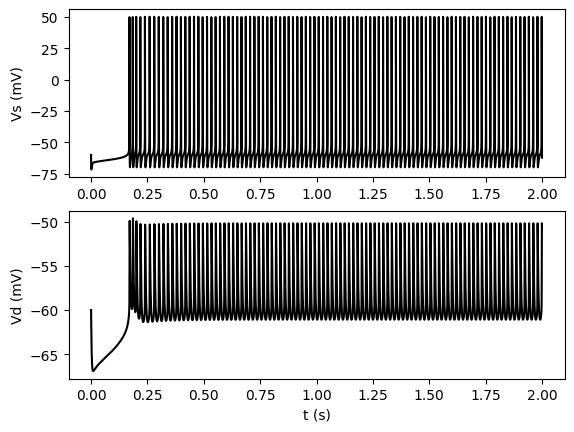

In [32]:
G_Link = 10e-9

def dALLdt(X,t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp = X

    alpha_m, alpha_h, alpha_n, beta_m, beta_h, beta_n = gating_soma(Vs)
    alpha_mca, alpha_mkca, alpha_mkahp, beta_mca, beta_mkca, beta_mkahp = gating_dend(Vd, Ca)

    IS_L = G_LS * (E_L - Vs)
    I_Na = G_Na * m**2 * h * (E_Na - Vs)
    I_K = G_K * n**2 * (E_K - Vs)
    I_c = G_Link * (Vd-Vs)

    ID_L = G_LD * (E_L - Vd)
    I_Ca = G_Ca * mca**2 * (E_Ca - Vd)
    I_KCa = G_KCa * mkca * min(4000*Ca, 1) * (E_K - Vd)
    I_KAHP = G_KAHP * mkahp * (E_K - Vd)


    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    dmcadt = alpha_mca * (1 - mca) - beta_mca * mca
    dmkcadt = alpha_mkca * (1 - mkca) - beta_mkca * mkca
    dmkahpdt = alpha_mkahp * (1 - mkahp) - beta_mkahp * mkahp

    dVsdt = (IS_inj + IS_L + I_Na + I_K + I_c) / CmS
    dVddt = (ID_inj + ID_L + I_Ca + I_KCa + I_KAHP - I_c) / CmD

    dCadt = convert_Ca*I_Ca - (Ca/tau_Ca)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt

val0 = [-0.06, -0.06, 0, 0, 0.5, 0.4, 0, 0.2, 0.2]

X = odeint(dALLdt, val0, t)
Vs = X[:,0]
Vd = X[:,1]

plt.subplot(2,1,1)
plt.plot(t, Vs*1000, 'k')
plt.ylabel('Vs (mV)')

plt.subplot(2,1,2)
plt.plot(t, Vd*1000, 'k')
plt.ylabel('Vd (mV)')
plt.xlabel('t (s)')
plt.show()

# <center>Gráficos para Gc = 50 nS</center>

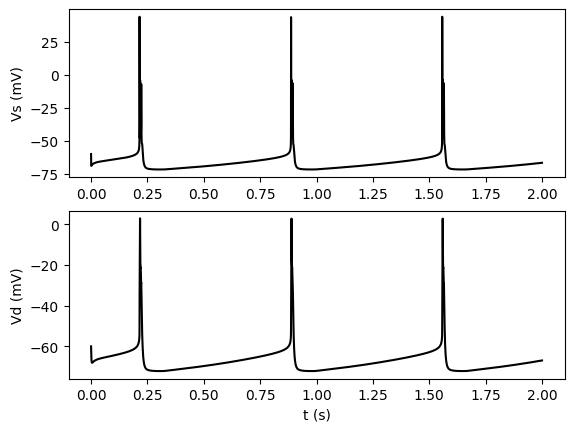

In [33]:
G_Link = 50e-9

def dALLdt(X,t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp = X

    alpha_m, alpha_h, alpha_n, beta_m, beta_h, beta_n = gating_soma(Vs)
    alpha_mca, alpha_mkca, alpha_mkahp, beta_mca, beta_mkca, beta_mkahp = gating_dend(Vd, Ca)

    IS_L = G_LS * (E_L - Vs)
    I_Na = G_Na * m**2 * h * (E_Na - Vs)
    I_K = G_K * n**2 * (E_K - Vs)
    I_c = G_Link * (Vd-Vs)

    ID_L = G_LD * (E_L - Vd)
    I_Ca = G_Ca * mca**2 * (E_Ca - Vd)
    I_KCa = G_KCa * mkca * min(4000*Ca, 1) * (E_K - Vd)
    I_KAHP = G_KAHP * mkahp * (E_K - Vd)


    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    dmcadt = alpha_mca * (1 - mca) - beta_mca * mca
    dmkcadt = alpha_mkca * (1 - mkca) - beta_mkca * mkca
    dmkahpdt = alpha_mkahp * (1 - mkahp) - beta_mkahp * mkahp

    dVsdt = (IS_inj + IS_L + I_Na + I_K + I_c) / CmS
    dVddt = (ID_inj + ID_L + I_Ca + I_KCa + I_KAHP - I_c) / CmD

    dCadt = convert_Ca*I_Ca - (Ca/tau_Ca)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt

val0 = [-0.06, -0.06, 0, 0, 0.5, 0.4, 0, 0.2, 0.2]

X = odeint(dALLdt, val0, t)
Vs = X[:,0]
Vd = X[:,1]

plt.subplot(2,1,1)
plt.plot(t, Vs*1000, 'k')
plt.ylabel('Vs (mV)')

plt.subplot(2,1,2)
plt.plot(t, Vd*1000, 'k')
plt.ylabel('Vd (mV)')
plt.xlabel('t (s)')
plt.show()

# <center>Gráficos para Gc = 100 nS</center>

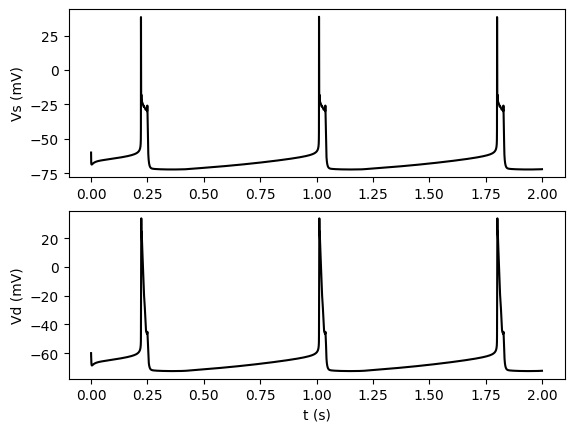

In [34]:
G_Link = 100e-9

def dALLdt(X,t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp = X

    alpha_m, alpha_h, alpha_n, beta_m, beta_h, beta_n = gating_soma(Vs)
    alpha_mca, alpha_mkca, alpha_mkahp, beta_mca, beta_mkca, beta_mkahp = gating_dend(Vd, Ca)

    IS_L = G_LS * (E_L - Vs)
    I_Na = G_Na * m**2 * h * (E_Na - Vs)
    I_K = G_K * n**2 * (E_K - Vs)
    I_c = G_Link * (Vd-Vs)

    ID_L = G_LD * (E_L - Vd)
    I_Ca = G_Ca * mca**2 * (E_Ca - Vd)
    I_KCa = G_KCa * mkca * min(4000*Ca, 1) * (E_K - Vd)
    I_KAHP = G_KAHP * mkahp * (E_K - Vd)


    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    dmcadt = alpha_mca * (1 - mca) - beta_mca * mca
    dmkcadt = alpha_mkca * (1 - mkca) - beta_mkca * mkca
    dmkahpdt = alpha_mkahp * (1 - mkahp) - beta_mkahp * mkahp

    dVsdt = (IS_inj + IS_L + I_Na + I_K + I_c) / CmS
    dVddt = (ID_inj + ID_L + I_Ca + I_KCa + I_KAHP - I_c) / CmD

    dCadt = convert_Ca*I_Ca - (Ca/tau_Ca)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt

val0 = [-0.06, -0.06, 0, 0, 0.5, 0.4, 0, 0.2, 0.2]

X = odeint(dALLdt, val0, t)
Vs = X[:,0]
Vd = X[:,1]

plt.subplot(2,1,1)
plt.plot(t, Vs*1000, 'k')
plt.ylabel('Vs (mV)')

plt.subplot(2,1,2)
plt.plot(t, Vd*1000, 'k')
plt.ylabel('Vd (mV)')
plt.xlabel('t (s)')
plt.show()